In [1]:
import Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
Pkg.instantiate()

In [2]:
using Aiyagari
using Plots
using PrettyTables
using Roots
using UnPack
using ProgressMeter

In [3]:
ProgressMeter.ijulia_behavior(:clear);
# pgfplotsx();
gr()
default(label = "", lw = 2, dpi = 300, left_margin = 0Plots.mm, format=:png);

In [4]:
# helper function
get_k(r, t, n) = k_from_mpk(t; mpk = mpk_from_after_tax_rK(t, r + t.δ), n)

get_k (generic function with 1 method)

# Mark-up Economy

In [5]:
e_μ = let
    #Household:
    ar1 = 0.9695
    sigmaP = sqrt(0.0384)/(1.2)
    sigmaIID = sqrt(0.0522)/(1.2)
    P, z_vals = calibration(5, 2 , ar1, sigmaP, sigmaIID)

    ies = 1.0
    crra = 5.5
    β = 0.993

    hh = Household(u = EZ(ies = ies, ra = crra), grid_points = 5_000,
        v = GHH(θ = 1.0, ν = 0.2), P = P, z_grid = z_vals, β = β, a_max = 10.0)

    #Technology
    δ = 0.1
    μ = 1.4
    α = .3
    #ρ = 0.7
    A_μ = 0.2
    # t_μ = MarkupTechnology(f = CES(α = α, ρ = 0.7), δ = δ, μ = μ, A = A_μ)
    t_μ = MarkupTechnology(f = CobbDouglas(α = α), δ = δ, μ = μ, A = A_μ)

    Economy(h = hh, t = t_μ)
end

Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, δ=0.1, μ=1.4, m=0.0, X=0.0

In [6]:
# Solve laissez-faire economy
r_range = (-0.0171, -0.016)
@time laissez_faire_μ = solve_laissez_faire(e_μ;
    r_range = r_range,
    tol =  (value_function = 1e-10, distribution = 1e-13)
)

Progress:  22 	 Time: 0:03:23
  r:       -0.016951711654663075
  excess:  -1.8274544655305647e-8

217.822852 seconds (1.99 G allocations: 30.760 GiB, 6.14% gc time, 7.22% compilation time)


r=-0.01695171165466308, b=0.0, k=0.5596544387010087, transfer=0.0,  y=0.21689893492861562, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, δ=0.1, μ=1.4, m=0.0, X=0.0

# Dynamic Efficient -- No change in K

## new steady state interest rate and eq

In [7]:
final_eq_μ = let
    r = -0.013930022583173161  # using a good guess
    b_target = laissez_faire_μ.y * 0.60
    k_target = laissez_faire_μ.k
    @time solve_new_stationary_equilibrium_given_k_b(
        laissez_faire_μ,
        k_target,
        b_target;
        r_range = (r - 1e-8, r + 1e-8),
        tol = (value_function = 1e-10, distribution = 1e-13)
    )
end

Progress:  5 	 Time: 0:00:30
  tr:      0.00012174253585941174
  excess:  5.576691608499829e-7
  r:       -0.01393002258317316

 30.711160 seconds (290.83 M allocations: 4.388 GiB, 6.09% gc time, 1.12% compilation time)


r=-0.013930022583173161, b=0.13013936095716935, k=0.5596544387010087, transfer=0.00012174253585941347,  y=0.21689893492861562, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, δ=0.1, μ=1.4, m=0.0, X=0.0

# trace out household savings

In [8]:
eq_μ = let
    y_0=laissez_faire_μ.y
    b_range = range(-0.5 * y_0, 3 * y_0, length = 20)
    k_target = laissez_faire_μ.k
    eqs = []
    for b in b_range
        push!(eqs,
            solve_new_stationary_equilibrium_given_k_b(
                laissez_faire_μ,
                k_target,
                b;
                r_range = (-0.05, 0.0),
                tol = (value_function = 1e-6, distribution = 1e-6)
            )
        )
    end
    eqs
end;

Progress:  31 	 Time: 0:01:41
  tr:      -0.0005159542795059348
  excess:  -5.186993312422672e-6
  r:       -0.0074120189819950584┌ Warning: amax is binding
└ @ Aiyagari /home/amador.manuel/Documents/Github/micro_risks_pareto_improving_policies/src/household_problem.jl:185
┌ Warning: Equilibrium is not valid
└ @ Aiyagari /home/amador.manuel/Documents/Github/micro_risks_pareto_improving_policies/src/stationary_equilibrium.jl:134


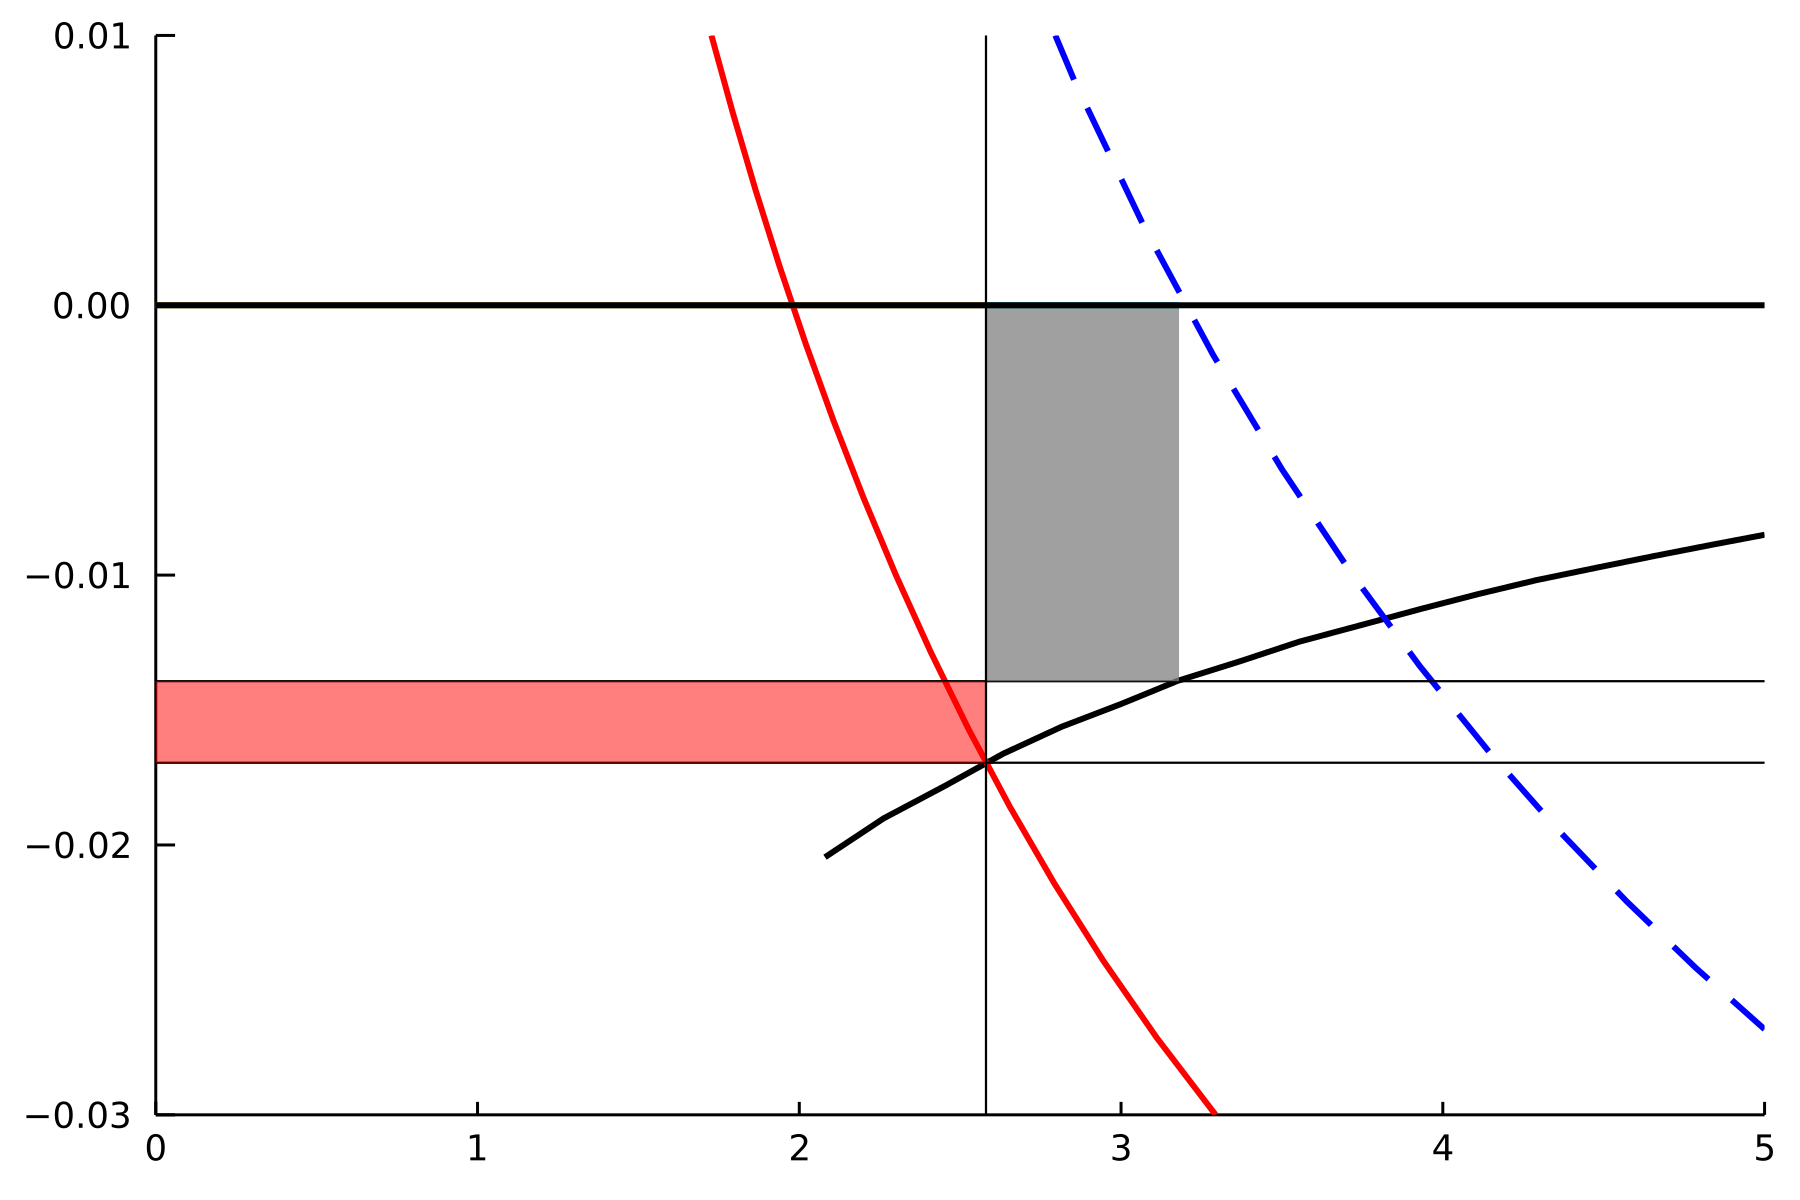

In [9]:
let
    t = get_t(laissez_faire_μ)
    n0 = laissez_faire_μ.n
    y0 = laissez_faire_μ.y
    y1 = final_eq_μ.y
    ky_0 = laissez_faire_μ.k / y0
    ky_1 = final_eq_μ.k / y1
    sy_1 = final_eq_μ.s / y1
    r_1 = final_eq_μ.r
    r_0 = laissez_faire_μ.r

    plot([(eq.s / y0, eq.r) for eq in eq_μ ], color = :black)
    plot!([(get_k(r, t, n0)/y0, r) for r in range(-0.03, 0.01, length = 15)], color = :red)
    plot!([(k / y0, mpk_from_factors(t, k = k, n = n0) - t.δ) for k in range(2 * y0, 5 * y0, length = 15)],
        color = :blue, style = :dash)

    ylims!(-0.03, 0.01)
    xlims!(0.0, 5)
    hline!([laissez_faire_μ.r, final_eq_μ.r], color = :black, lw = 0.75)

    plot!([0,ky_0],             # xlims for shade
         [0,0],                   # dummy y coordinates
         fillrange = (r_0,r_1), # apply ylims
         fillalpha = 0.5,         # set transparency
         fillcolor=:red,         # set shade color
         label = "Cost: Δr*K/Y")

    plot!([ky_0,final_eq_μ.s/y0],             # xlims for shade
             [0,0],                   # dummy y coordinates
             fillrange = (r_1,0.0), # apply ylims
             fillalpha = 0.75,         # set transparency
             fillcolor=:gray,         # set shade color
             label = "Revenue: r*dS", legend=false, grid=false)

    hline!([0], color = :black, lw = 2)
    vline!([laissez_faire_μ.k / laissez_faire_μ.y], color = :black, lw = 0.75)
end

In [10]:
savefig(joinpath(@__DIR__, "..", "output", "figures", "CostBenefit_Efficient.pdf"))

# Crowding in

In [11]:
kGR = golden_rule_k(e_μ.t, laissez_faire_μ.n)

0.6941165699188552

In [12]:
eq_crowdin = let
    y_0 = laissez_faire_μ.y
    eq_crowdin = []
    b_range = range(-0.5 * y_0,0.0, length=5)
    for b in b_range
        push!(eq_crowdin,
            solve_new_stationary_equilibrium_given_k_b(
                laissez_faire_μ,
                laissez_faire_μ.k,
                b;
                r_range = (-0.05, 0.0),
                tol = (value_function = 1e-6, distribution = 1e-6)
            )
        )
    end

    k_range = range(laissez_faire_μ.k,kGR, length = 10)
    for k in k_range
        push!(eq_crowdin,
            solve_new_stationary_equilibrium_given_k_b(
                laissez_faire_μ ,
                k,
                0.0;
                r_range = (-0.05, 0.0),
                tol = (value_function = 1e-6, distribution = 1e-6)
            )
        )
    end

    b_range = range(0.0, 2.5 * y_0, length = 15)
    for b in b_range
        push!(eq_crowdin,
            solve_new_stationary_equilibrium_given_k_b(
                laissez_faire_μ ,
                kGR,
                b;
                r_range = (-0.05, 0.0),
                tol = (value_function = 1e-6, distribution = 1e-6)
            )
        )
    end


    eq_crowdin
end

Progress:  31 	 Time: 0:01:38
  tr:      0.0001693581997553109
  excess:  -0.005223189305484599
  r:       -0.006979673943715167┌ Warning: amax is binding
└ @ Aiyagari /home/amador.manuel/Documents/Github/micro_risks_pareto_improving_policies/src/household_problem.jl:185
┌ Warning: Equilibrium is not valid
└ @ Aiyagari /home/amador.manuel/Documents/Github/micro_risks_pareto_improving_policies/src/stationary_equilibrium.jl:134


30-element Vector{Any}:
 r=-0.02045303865452296, b=-0.10844946746430781, k=0.5596544387010087, transfer=-0.00025858795329466826,  y=0.21689893492861562, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, δ=0.1, μ=1.4, m=0.0, X=0.0
 r=-0.019451269350247446, b=-0.08133710059823085, k=0.5596544387010087, transfer=-0.00018322129278132253,  y=0.21689893492861562, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, δ=0.1, μ=1.4, m=0.0, X=0.0
 r=-0.018525391659932205, b=-0.054224733732153904, k=0.5596544387010087, transfer=-0.00012381742999981182,  y=0.21689893492861562, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=5000, a_max=10.0, a_min=0.0, C

In [13]:
@time crowdin_final = solve_new_stationary_equilibrium_given_k_b(
    laissez_faire_μ,
    kGR,
    0.6 * laissez_faire_μ.y;
    r_range = (laissez_faire_μ.r, -0.010),
    tol = (value_function = 1e-10, distribution = 1e-13)
)

Progress:  21 	 Time: 0:06:16
  tr:      0.0008023211241791044
  excess:  -7.97062453117281e-6
  r:       -0.01123726202721445

376.843379 seconds (3.77 G allocations: 56.244 GiB, 6.82% gc time)


r=-0.011237262027214453, b=0.13013936095716935, k=0.6941165699188552, transfer=0.0008023211241791062,  y=0.23137218997295173, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, δ=0.1, μ=1.4, m=0.0, X=0.0

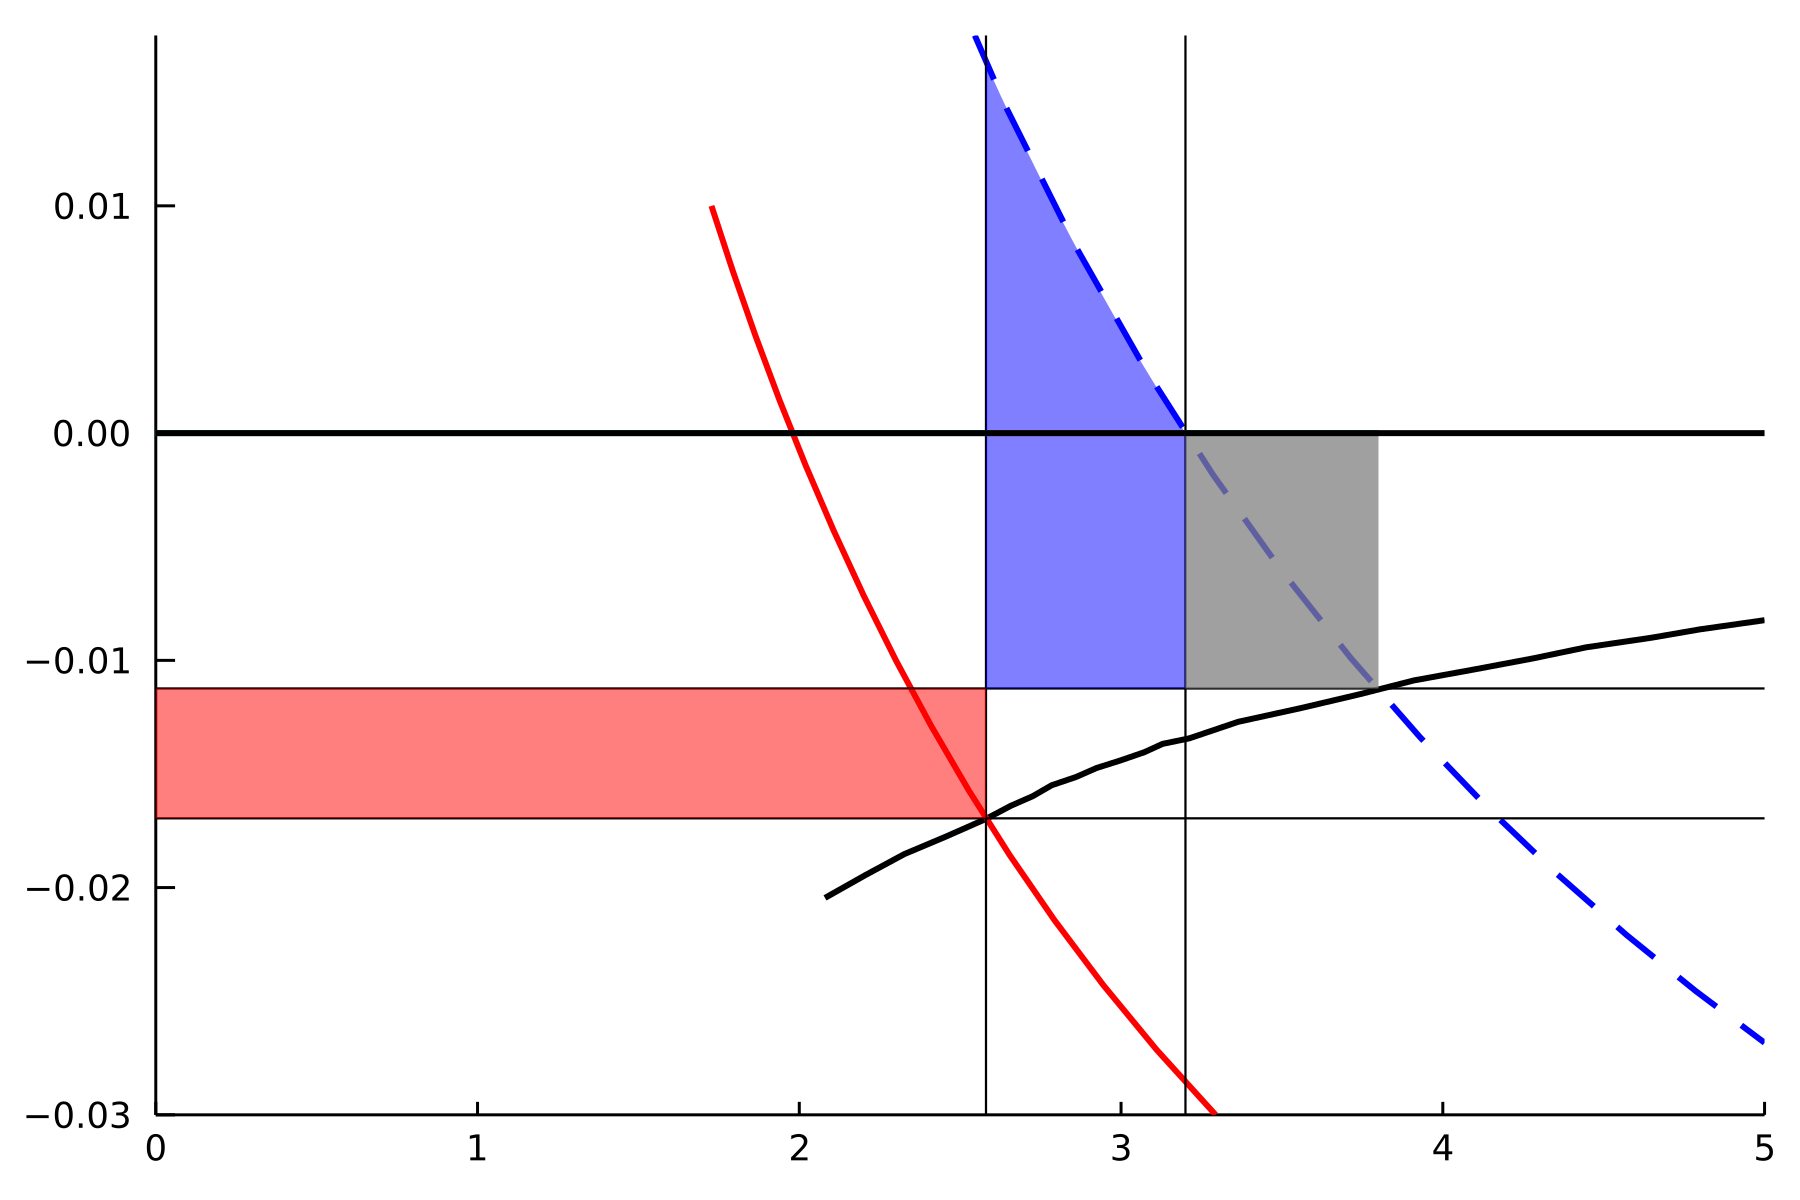

In [14]:
let
    r_0 = laissez_faire_μ.r
    t = get_t(laissez_faire_μ)
    n0 = laissez_faire_μ.n
    y0 = laissez_faire_μ.y
    y1 = crowdin_final.y
    ky_0 = laissez_faire_μ.k / y0
    ky_1 = crowdin_final.k / y1
    sy_1 = crowdin_final.s / y1
    r_1 = crowdin_final.r

    plot([(eq.s / y0, eq.r) for eq in eq_crowdin], color = :black)
    plot!([(get_k(r, t, n0)/y0, r) for r in range(-0.03, 0.01, length = 15)], color = :red)
    plot!([ (k / y0, mpk_from_factors(t, k = k, n = n0) - t.δ) for k in range(2 * y0, 5 * y0, length = 15)],
        color = :blue, style = :dash)
    ylims!(-0.03, 0.0175)
    xlims!(0.0, 5)
    hline!([laissez_faire_μ.r, crowdin_final.r], color = :black, lw = 0.75)
    vline!([laissez_faire_μ.k / laissez_faire_μ.y, kGR/laissez_faire_μ.y], color = :black, lw = 0.75)

    plot!([0,ky_0],             # xlims for shade
         [0,0],                   # dummy y coordinates
         fillrange = (r_0,r_1), # apply ylims
         fillalpha = 0.5,         # set transparency
         fillcolor=:red,         # set shade color
         label = "Cost: Δr*K/Y")

    plot!([  (k / y0, mpk_from_factors(t, k = k, n = n0) - t.δ) for k in range(laissez_faire_μ.k,kGR, length = 15)],
        fill = (0, 0.5, :blue),lw=0.0)

    plot!([ky_0,crowdin_final.k /y0],             # xlims for shade
        [0,0],                   # dummy y coordinates
        fillrange = (r_1,0.0), # apply ylims
        fillalpha = 0.5,         # set transparency
        fillcolor=:blue,         # set shade color
        label = "Revenue I: (MPK-δ)* ΔK/Y")

    plot!([crowdin_final.k /y0,crowdin_final.s/y0],             # xlims for shade
        [0,0],                   # dummy y coordinates
        fillrange = (r_1,0.0), # apply ylims
        fillalpha = 0.75,         # set transparency
        fillcolor=:gray,         # set shade color
        label = "Revenue II: r*ΔS/Y")

    hline!([0], color = :black, lw = 2,legend=false, grid=false)
end

In [15]:
savefig(joinpath(@__DIR__, "..", "output", "figures", "CostBenefit_Crowdin.pdf"))

# Competititive Case

In [22]:
e = let
    P, z_vals = let
        ar1 = 0.9695
        sigmaP = sqrt(0.0384)/(1.2)
        sigmaIID = sqrt(0.0522)/(1.2)
         calibration(5, 2 , ar1, sigmaP, sigmaIID)
    end
    # Technology
    t = let
        θ = 0.3
        ls = 1 - θ
        δ = 0.1
        #α1, A1 = get_tech_params(1, θ = θ)
        A1=1.0
        α1=0.3
        Technology(f = CobbDouglas(α = α1), δ = δ)
    end
    # Households
    h = let
        ies = 1.0
        β = 0.99 #* (1 + g)^(1 - 1/ies)
        Household(
            u = EZ(ies = 1.0, ra = 5.5),
            v = GHH(θ = 1.0, ν = 0.2),
            P = P, z_grid = z_vals, β = β, a_max = 100.0)
    end
    Economy(h = h, t = t)
end

Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, δ=0.1

In [23]:
# Solve laissez-faire economy
r_range = (-0.0172, -0.0171) # narrowing the range
@time laissez_faire = solve_laissez_faire(e;
    r_range = r_range,
    tol =  (value_function = 1e-10, distribution = 1e-13)
)

Progress:  19 	 Time: 0:04:31
  r:       -0.017178158569335928
  excess:  1.3117266375317627e-6

271.662270 seconds (2.72 G allocations: 40.632 GiB, 6.72% gc time, 0.06% compilation time)


r=-0.01717815856933593, b=0.0, k=6.902156580943709, transfer=0.0,  y=1.9054977262551143, Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, δ=0.1

In [24]:
@time final_eq = let
    tol = (value_function = 1e-7, distribution = 1e-8)
    b_target = laissez_faire.y*0.6
    r_range_2 = (-0.0152, -0.0148)  # narrowing the range
    solve_new_stationary_equilibrium_given_k_b(laissez_faire; r_range = r_range_2, tol) do (r)
        # returns k consistent with r and no capital taxes
        t = get_t(laissez_faire)
        b = b_target
        rK = rK_from_r(;t, r)
        mpk = mpk_from_after_tax_rK(t, rK)
        k = k_from_mpk(t; mpk, laissez_faire.n)
        return (k, b)
    end
end

Progress:  17 	 Time: 0:01:47
  tr:      0.0025568388674737236
  excess:  -8.477799796047236e-5
  r:       -0.015021142578124995

108.527053 seconds (1.07 G allocations: 16.028 GiB, 6.79% gc time, 0.87% compilation time)


r=-0.015021142578124997, b=1.1432986357530686, k=6.653242778527226, transfer=0.0025568388674737375,  y=1.8846165648986157, Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, δ=0.1

In [25]:
eq_nomarkup = let  r_range = [-.03,0.0], tol = (value_function = 1e-7, distribution = 1e-8)
    b_range = range(-1.0 * laissez_faire.y, 4.5 * laissez_faire.y, length = 15)
    eq_nomarkup = []
    for b in b_range
        push!(eq_nomarkup,
            solve_new_stationary_equilibrium_given_k_b(laissez_faire; r_range, tol) do  (r)
                # returns k consistent with r and no capital taxes
                t = get_t(laissez_faire)
                rK = rK_from_r(;t, r)
                mpk = mpk_from_after_tax_rK(t, rK)
                k = k_from_mpk(t; mpk, laissez_faire.n)
                return (k, b)
            end
        )
    end
    eq_nomarkup
end

Progress:  31 	 Time: 0:06:41
  tr:      -0.007079042859550938
  excess:  0.0002109465429125379
  r:       -0.006829186109825965┌ Warning: amax is binding
└ @ Aiyagari /home/amador.manuel/Documents/Github/micro_risks_pareto_improving_policies/src/household_problem.jl:185
┌ Warning: Equilibrium is not valid
└ @ Aiyagari /home/amador.manuel/Documents/Github/micro_risks_pareto_improving_policies/src/stationary_equilibrium.jl:134


15-element Vector{Any}:
 r=-0.021659835902973996, b=-1.9054977262551143, k=7.473080699623325, transfer=-0.00908898369886739,  y=1.9514745610626976, Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, δ=0.1
 r=-0.01975391727872192, b=-1.156909333797748, k=7.220816268207739, transfer=-0.004670053985321637,  y=1.931474065245829, Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, δ=0.1
 r=-0.018038963796570884, b=-0.4083209413403817, k=7.005947315936439, transfer=-0.0013797913216396368,  y=1.914049005335945, Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, δ=0.1
 r=-0.016498622251674522, 

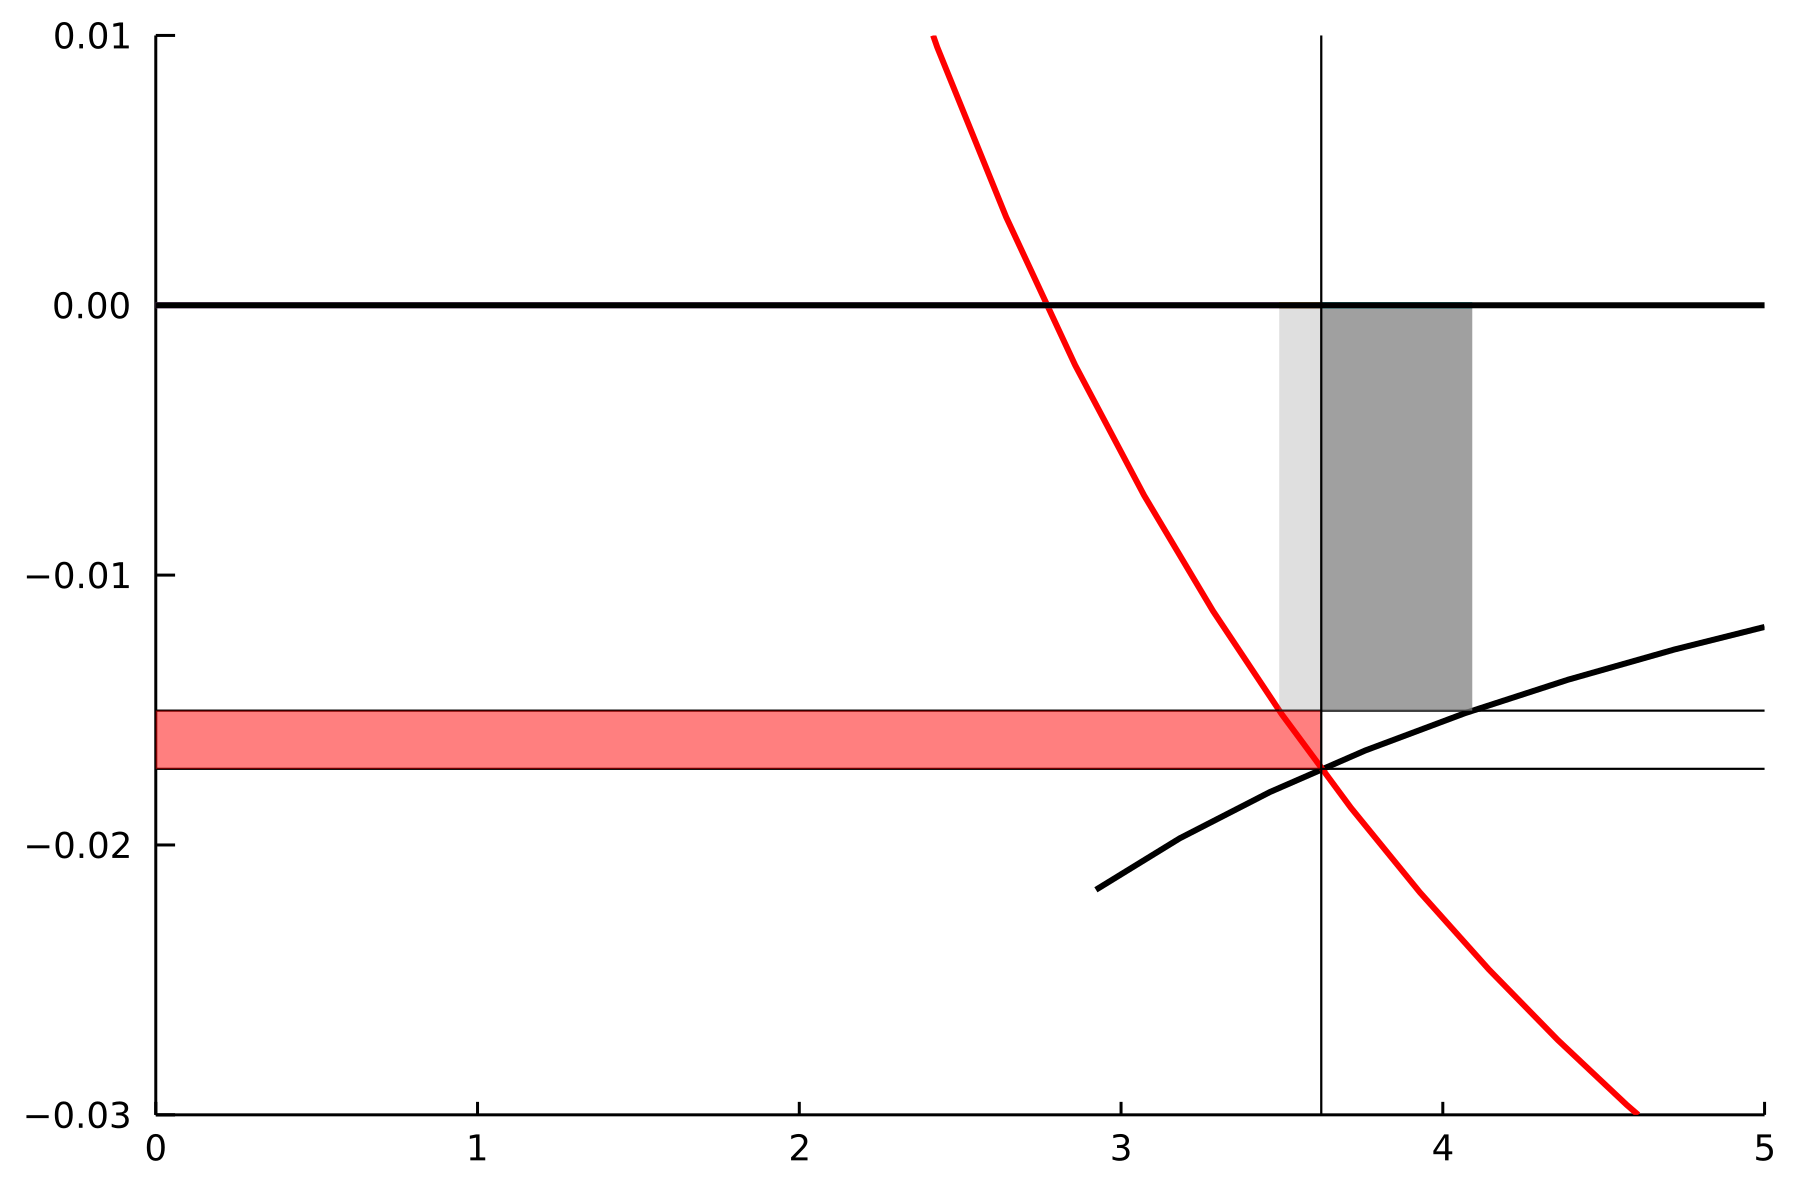

In [26]:
let
    t = get_t(laissez_faire)
    n0 = laissez_faire.n
    y0 = laissez_faire.y
    y1 = final_eq.y
    ky_0 = laissez_faire.k / y0
    ky_1 = final_eq.k / y1
    sy_1 = final_eq.s / y1
    r_1 = final_eq.r

    plot([(eq.s / y0, eq.r) for eq in eq_nomarkup], color = :black)
    plot!([ (k / y0, mpk_from_factors(t, k = k, n = n0) - t.δ) for k in range(2 * y0, 5 * y0, length = 15)], color = :red)

    ylims!(-0.03, 0.01)
    xlims!(0.0, 5)
    hline!([laissez_faire.r, final_eq.r], color = :black, lw = 0.75)

    plot!([0,ky_0],             # xlims for shade
         [0,0],                   # dummy y coordinates
         fillrange = (laissez_faire.r,r_1), # apply ylims
         fillalpha = 0.5,         # set transparency
         fillcolor=:red,         # set shade color
         label = "Cost: Δr*K/Y")

    plot!([ky_0,final_eq.k/y0],             # xlims for shade
         [0,0],                   # dummy y coordinates
         fillrange = (r_1,0.0), # apply ylims
         fillalpha = 0.25,         # set transparency
         fillcolor=:gray,         # set shade color
         label = "Revenue I: r*dK")

    plot!([ky_0,final_eq.s/y0],             # xlims for shade
         [0,0],                   # dummy y coordinates
         fillrange = (r_1,0.0), # apply ylims
         fillalpha = 0.75,         # set transparency
         fillcolor=:gray,         # set shade color
         label = "Revenue II: r*dS")

    hline!([0], color = :black, lw = 2)
    vline!([laissez_faire.k / laissez_faire.y], color = :black, lw = 0.75, legend=false,grid=false)

end

In [27]:
savefig(joinpath(@__DIR__, "..", "output", "figures", "CostBenefit_Nomarkup.pdf"))